In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

Using TensorFlow backend.


In [3]:
epochs = 3
batch_size = 50

In [4]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [5]:
def generate_model():

    model = Sequential()

    # First LSTM layer defining the input sequence length
    model.add(LSTM(input_shape=(sequence_length-1, 1),
                   units=32,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer with 128 units
    model.add(LSTM(units=128,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer with 100 units
    model.add(LSTM(units=100,
                   return_sequences=False))
    model.add(Dropout(0.2))

    # Densely-connected output layer with the linear activation function
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    return model

In [6]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [7]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [8]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('datasets/cpu-utilization/cpu-full-b.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].as_matrix()

    # train on first 700 samples and test on next 300 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)

    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (160, 99)


/Users/mac7/opt/anaconda3/envs/myenvpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Training...
Train on 475 samples, validate on 25 samples
Epoch 1/3
475/475 [==============================] - 3s 6ms/step - loss: 0.3949 - val_loss: 0.2349
Epoch 2/3
475/475 [==============================] - 2s 4ms/step - loss: 0.2090 - val_loss: 0.5448
Epoch 3/3
475/475 [==============================] - 2s 4ms/step - loss: 0.2224 - val_loss: 0.2016
Predicting...
Reshaping predicted


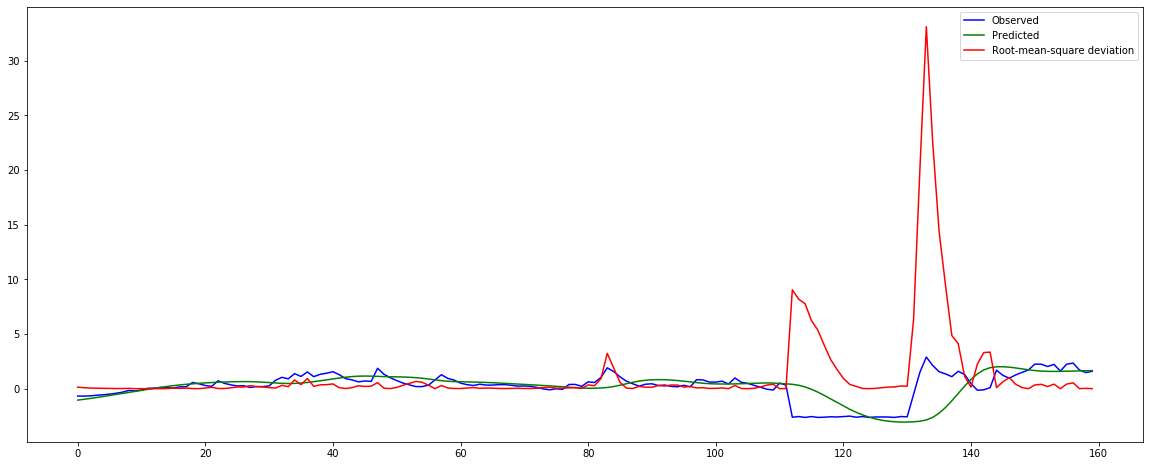

Training duration:8.776865005493164


In [9]:
model, y_test, predicted = run()